In [31]:
def convert_to_corner(points):
    return np.concatenate(
        [points[..., :2] - points[..., 2:] / 2.0, points[..., :2] + points[..., 2:] / 2.0],
        axis=-1,
    )

In [32]:
box1 = np.array([122.6812, 86.33962, 200.19618, 208.15094])
box2 = np.array([121.18585, 89.18585, 208.9793, 206.27695])

box1_corner = np.maximum(convert_to_corner(box1), 0.)
box2_corner = np.maximum(convert_to_corner(box2), 0.)

In [34]:
lu = np.maximum(box1_corner[..., :2], box2_corner[..., :2])    # intersection left top
rd = np.minimum(box1_corner[..., 2:], box2_corner[...,  2:])

lu, rd

(array([22.58311,  0.     ]), array([222.77929, 190.41509]))

In [35]:
intersection = np.maximum(np.zeros_like(rd - lu), rd - lu)    # intersection width, height
intersection_area = intersection[..., 0] * intersection[..., 1]

In [40]:
box1_area = (box1[..., 2] - box1[..., 0]) * (box1[..., 3] - box1[..., 1])
box2_area = (box2[..., 2] - box2[..., 0]) * (box2[..., 3] - box2[..., 1])
union_area = np.maximum(
    box1_area + box2_area - intersection_area, 1e-8
)
tf.clip_by_value(intersection_area / union_area, 0.0, 1.0)

<tf.Tensor: shape=(), dtype=float64, numpy=1.0>

In [42]:
box1[..., 2] - box1[..., 0]

77.51498

In [41]:
box1_area

9442.2020335736

In [22]:
np.array([122.6812, 89.18585]) - np.array([200.19618, 206.27695])

array([ -77.51498, -117.0911 ])

In [1]:
import tensorflow as tf
from tensorflow import keras
import cv2
import matplotlib.pyplot as plt
import numpy as np

from utils import data_utils
from models import network

In [17]:
model = network.build_model()
model.load_weights('./ckpt/detector')
decoder = network.OutputDecoder(score_threshold=0.05)

In [18]:
inputs = model.input
out = decoder(model.output)
final_model = keras.models.Model(inputs, out)

In [19]:
val_ds = data_utils.get_val_dataset(batch_size=4)
train_ds = data_utils.get_train_dataset(batch_size=4)
for i in train_ds.take(4):
    sample = i
sample[0].shape, sample[1].shape

(TensorShape([4, 224, 224, 3]), TensorShape([4, 7, 7, 25]))

In [20]:
valid_num, nms_boxes, nms_scores, nmsed_classes = final_model.predict(sample[0])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


0 [118.38771 190.16734 213.94356 175.37227]
0 [219.97249 295.50287 132.02171  70.76607]
1 [127.3938   71.67731 191.7905  141.48488]
1 [ 91.56773     6.0548267 124.8315     32.290123 ]
2 [ 35.48017   10.223564 233.76541  198.04773 ]
3 [114.54567  92.75786 144.9822  103.19353]


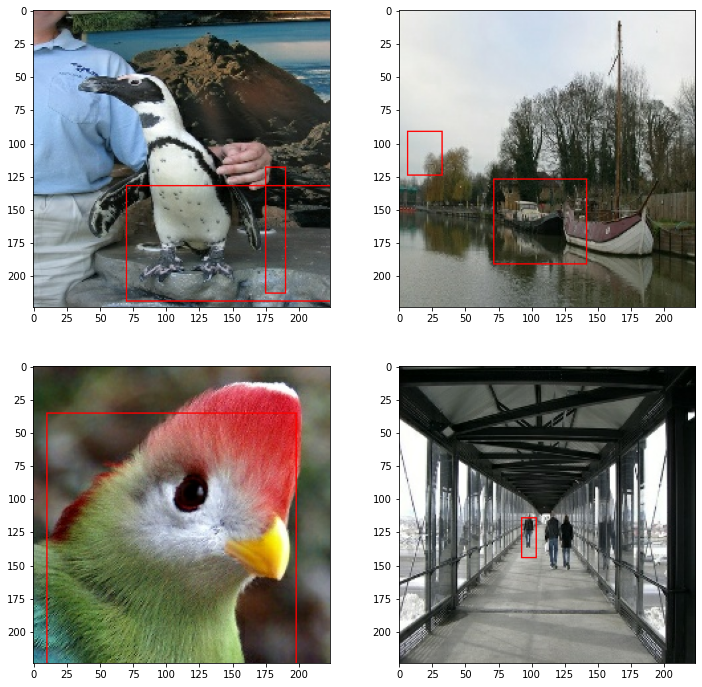

In [21]:
plt.figure(figsize=(12, 12))
for i in range(4):
    image = (sample[0][i].numpy() + 1) / 2
    for box in nms_boxes[i][:valid_num[i]]:
        print(i, box)
        pt1 = (int(box[1]), int(box[0]))
        pt2 = (int(box[3]), int(box[2]))
        image = cv2.rectangle(image, pt1, pt2, (255, 0, 0), 1)
    plt.subplot(2, 2, i + 1)
    plt.imshow(image)

In [10]:
sample_pred = np.zeros(shape=(4, 7, 7, 130))
sample_pred[..., :5] = sample[1][..., :5]
sample_pred[..., 10:] = sample[1][...,5:]

ValueError: could not broadcast input array from shape (4,7,7,20) into shape (4,7,7,120)

In [45]:
boxes, scores, _ = decoder(sample_pred)
valid_num = boxes.valid_detections
nms_boxes = boxes.nmsed_boxes
nms_scores = boxes.nmsed_scores

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


0 tf.Tensor([ 79.058815  95.30182  221.80392  221.55637 ], shape=(4,), dtype=float32)
1 tf.Tensor([109.93547      0.44799805 223.48387    221.312     ], shape=(4,), dtype=float32)
2 tf.Tensor([ 35.839996  30.464005 171.584    197.71733 ], shape=(4,), dtype=float32)
3 tf.Tensor([ 16.144142     0.44800568 223.32733    206.07999   ], shape=(4,), dtype=float32)


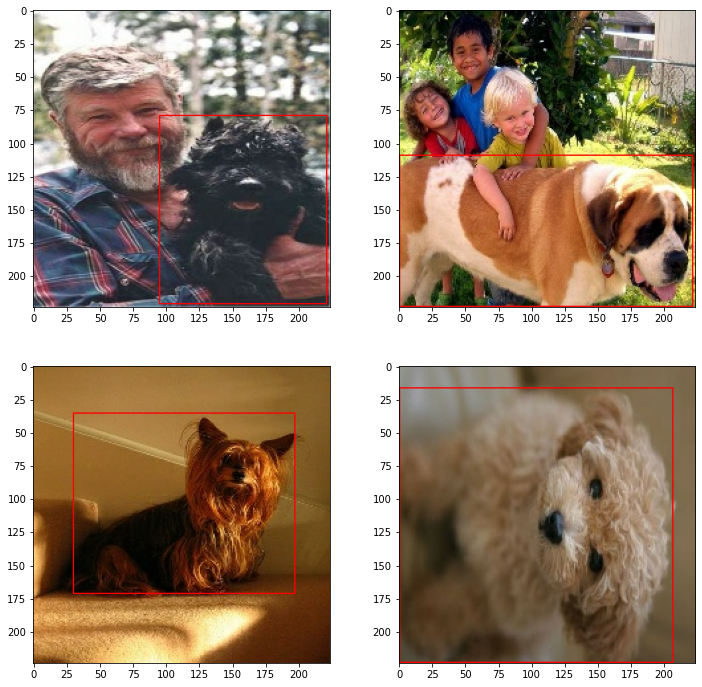

In [46]:
plt.figure(figsize=(12, 12))
for i in range(4):
    image = (sample[0][i].numpy() + 1) / 2
    for box in nms_boxes[i][:valid_num[i]]:
        print(i, box)
        pt1 = (int(box[1]), int(box[0]))
        pt2 = (int(box[3]), int(box[2]))
        image = cv2.rectangle(image, pt1, pt2, (255, 0, 0), 1)
    plt.subplot(2, 2, i + 1)
    plt.imshow(image)

In [19]:
tf.where(sample[1][1, :, :, 4])

<tf.Tensor: shape=(1, 2), dtype=int64, numpy=array([[3, 3]], dtype=int64)>

In [20]:
pred[1, 3, 3, 4]

1.0020255

In [27]:
pred[1, 3, 3, 10:].max()

0.19186947

In [25]:
classes = pred[..., 10:]
score1 = pred[..., 4, None]
score1 = tf.reshape(self._get_confidence(score1, classes), (-1, 7 * 7, 120))

-0.0

In [ ]:
    def _get_confidence(self, conf, class_):
        confidence_score = class_ * conf
        mask = tf.where(confidence_score > 0.2, 1., 0.)
        return confidence_score * mask

In [10]:
temp = np.array([1, 2]).astype(np.float32)

In [11]:
temp

array([1., 2.], dtype=float32)